In [3]:
from pyspark.sql.functions import mean, udf, col, round
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [4]:
%matplotlib inline
now = datetime.datetime.now()
print(now)
df1 = spark.read.csv('../data/pluto.csv', header=True)
df2 = spark.read.csv('../data/pluto_18v2_1.csv', header=True)

2019-05-29 18:51:06.717054


In [5]:
for i in df1.columns:
    if i not in df2.columns:
        df1 = df1.drop(i)

In [6]:
len(df1.columns) == len(df2.columns)

True

In [7]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])

double_columns = ['bldgarea', 'facilfar','residfar', 'commfar', 
                  'numbldgs', 'numfloors', 'bldgdepth','bldgfront', 
                  'lotdepth', 'lotfront','exemptland', 'exempttot', 
                  'assessland', 'assesstot','builtfar']
cols = df2.columns
df1 = df1.select(cols)
df2 = df2.select(cols)

for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
    
df1 = df1.select([col(A).alias(A+'_1') for A in df1.schema.names])

colnames = zip(df1.columns, df2.columns)

df = df2.join(df1, df2['bbl'] == df1['bbl_1'])

In [8]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0
    
access_cols = ['exemptland', 'exempttot', 'assessland', 'assesstot']

@udf #special access column comparison
def compare_a(col1,col2):
    try: 
        if abs(col1 - col2) > 10: 
            return 1
        else: 
            return 0
    except: 
        return 0

In [9]:
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    if B in access_cols:
        df = df.withColumn(B+'%', compare_a(col(A),col(B)))\
               .drop(A,B)
    else:
        df = df.withColumn(B+'%', compare(col(A),col(B)))\
                   .drop(A,B)
        
results = df.select(*[mean(col(A)).alias(A) for A in df.columns])

In [10]:
start_time = time.time()
results_df = results.toPandas()
elapsed_time = time.time() - start_time

In [11]:
results_df.iloc[0,:].sort_values(ascending=False)[0:30]

edesigdate%       1.000000
basempdate%       1.000000
landmkdate%       1.000000
zoningdate%       1.000000
dcasdate%         1.000000
rpaddate%         1.000000
condono%          0.999294
landuse%          0.953318
appbbl%           0.892796
plutomapid%       0.892572
tract2010%        0.887042
assessland%       0.821543
assesstot%        0.821424
sanitdistrict%    0.565764
ext%              0.527255
residfar%         0.437605
ownername%        0.305397
yearalter1%       0.105968
schooldist%       0.087399
appdate%          0.080464
address%          0.036453
yearalter2%       0.017961
builtfar%         0.014599
numfloors%        0.013098
yearbuilt%        0.012154
lotarea%          0.011005
lotfront%         0.010416
lotdepth%         0.010234
bldgdepth%        0.010053
bldgfront%        0.008205
Name: 0, dtype: float64

In [12]:
elapsed_time/60

5.067297041416168

In [13]:
results0 = pd.read_csv('results_18v1_18v2_1.csv', index_col = False)

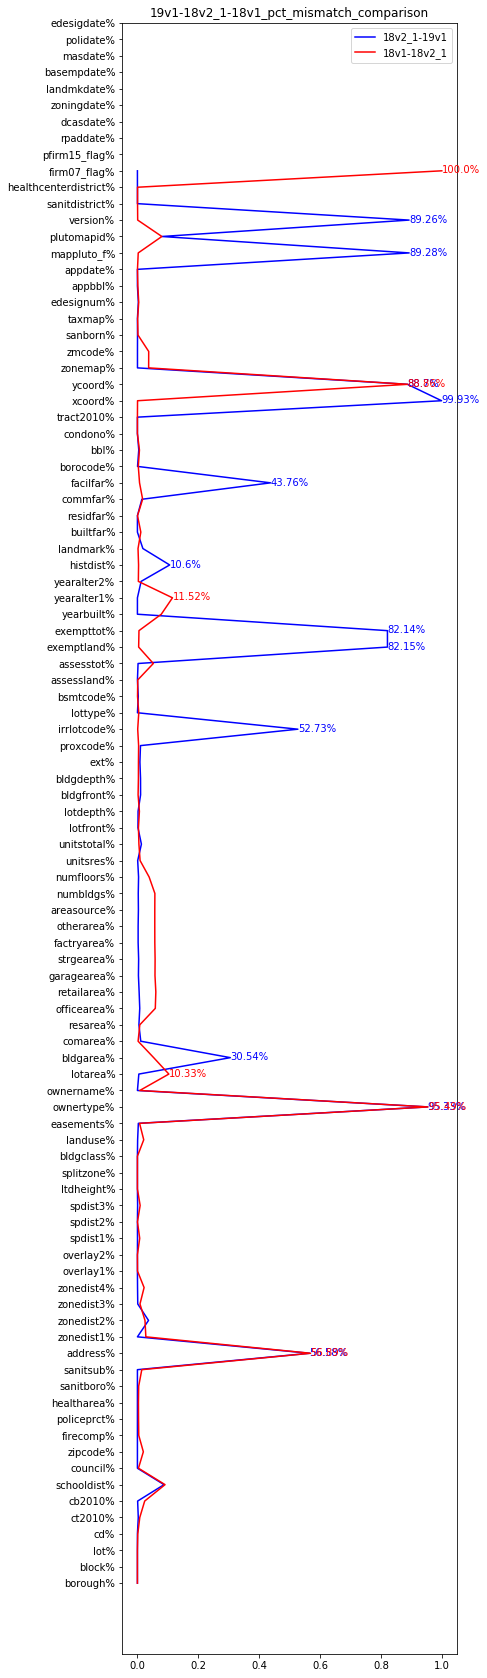

In [16]:
plt.figure(figsize=(6, 30))

plt.plot(results_df.loc[0, results0.columns], range(len(results_df.loc[0, results0.columns])), label = '18v2_1-19v1', color = 'blue')
plt.plot(results0.iloc[0, :], range(len(results0.columns)), label = '18v1-18v2_1', color = 'red')

label = list(results_df.loc[0, results0.columns])
label0 = list(results0.iloc[0, :])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(len(label0)):
    if label0[i] >= 0.1:
        plt.text(x = label0[i] , y = i-0.15, s = '{}%'.format(np.round(label0[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(96), results_df.columns, rotation='horizontal')
plt.legend()
plt.title('19v1-18v2_1-18v1_pct_mismatch_comparison')
plt.savefig('19v1-18v2_1-18v1_pct_mismatch_comparison.png', bbox_inches='tight')
plt.show()